<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/cell_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_img_full.zip
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_seg.zip
!unzip -o -d ./images MP6843_img_full.zip
!unzip -o -d ./labels MP6843_seg.zip
!rm *.zip

In [2]:
from os.path import join
from os import listdir
import numpy as np
import cv2
import torch
from torch import nn, optim, float
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [3]:
im_root, lb_root = "./images", "./labels"
im_files = [join(im_root, im) for im in sorted(listdir(im_root)) if 'w1' in im]
lb_files = [join(lb_root, lb) for lb in sorted(listdir(lb_root)) if '_01' in lb]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
dim = (696, 520)
images = [cv2.resize(cv2.imread(img), dim, interpolation = cv2.INTER_AREA) for img in im_files]
images = np.array(images)

In [5]:
labels = [cv2.imread(lbl,0) for lbl in lb_files]
labels = (np.array(labels)/255)

In [6]:
class CellImages(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(256),
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = self.transform(self.images[ind])
        lbl = self.transform(self.labels[ind])
        return img, lbl

In [19]:
train = DataLoader(CellImages(images[0:70], labels[0:70]), batch_size=10, shuffle=False)
test = DataLoader(CellImages(images[70:90], labels[70:90]), batch_size=10, shuffle=False)

In [8]:
def show_cuda_image(runs, *args):
    for ind in range(runs):
        i = 0
        f, ax = plt.subplots(1,len(args), figsize=(10,10))
        for arg in args:
            ax[i].imshow(arg[ind].cpu().numpy()[0])
            ax[i].grid()
            i = i + 1
    plt.show()

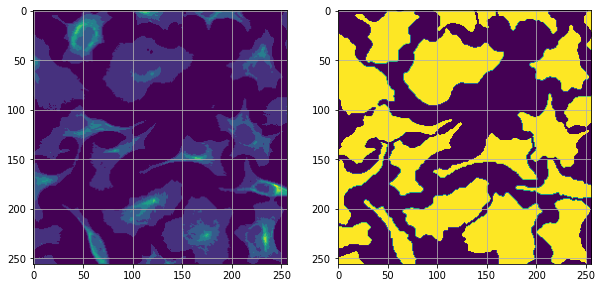

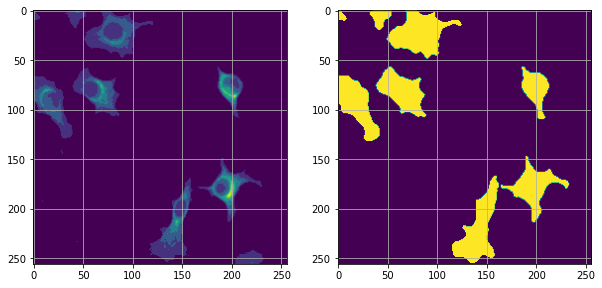

In [9]:
for i, sample in enumerate(train):
    if i == 3:
        img, lbl = sample
        show_cuda_image(2, img.to(device), lbl.to(device))
        del img, lbl
        torch.cuda.empty_cache()
        break

In [10]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, (3, 3), bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, (3, 3),  bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.stack(x)
        return x

In [11]:
class Contracting(nn.Module):
    """3x3 convolutions & ReLU followed by 2x2 max pooling for downsampling"""

    def __init__(self, channels):
        super().__init__()
        self.ch = channels
        # Generate sequence of required layers
        self.blocks = nn.ModuleList(
            [Block(self.ch[i], self.ch[i + 1]) for i in range(len(self.ch) - 1)]
        )
        self.pool = nn.MaxPool2d((2,2), stride=2)

    def forward(self, x):
        features = []
        for i in range(len(self.ch) - 1):
            x = self.blocks[i](x)
            features.append(x)  # Store block outputs for concatenation
            x = self.pool(x)  # 2x2 max pooling
        return features

In [12]:
class Expansive(nn.Module):
    """Upsampling followed by 3x3 convolutions & ReLU"""

    def __init__(self, channels):
        super().__init__()
        self.ch = channels
        # Generate sequence of required layers
        self.upconv = nn.ModuleList(
            [nn.ConvTranspose2d(self.ch[i], self.ch[i + 1], 
                                (2, 2), stride=2) for i in range(len(self.ch) - 1)]
        )
        self.blocks = nn.ModuleList(
            [Block(self.ch[i], self.ch[i + 1]) for i in range(len(self.ch) - 1)]
        )
    
    def forward(self, x, features):
        for i in range(len(self.ch) - 1):
            x = self.upconv[i](x)
            feat = self.crop(features[i], x)
            x = torch.cat([x, feat], dim=1)  # Double the number of feature channels
            x = self.blocks[i](x)
        return x

    def crop(self, features, block):  
        """Necessary due to loss of border pixels every convolution"""
        _, _, h, w = block.shape
        features = transforms.CenterCrop([h, w])(features)
        return features

In [13]:
class UNet(nn.Module):
    def __init__(self, channels, output_size, final_output=1):
        super(UNet, self).__init__()
        self.down = channels  # Number of feature channels
        self.up = [c for c in reversed(channels[1:])]

        self.enc = Contracting(self.down)
        self.dec = Expansive(self.up)

        self.final = nn.Conv2d(self.up[-1], final_output, (1, 1))  # 1x1 convolutional layer
        self.output_size = output_size  

    def forward(self, x):
        enc_features = self.enc(x)
        x = self.dec(enc_features[-1], enc_features[::-1][1:])
        x = self.final(x)
        x = F.interpolate(x, self.output_size)
        return x

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """Training batch to update weights and biases"""
    size = len(dataloader.dataset)

    for i, (img, lbl) in enumerate(dataloader):
        img_batch, lbl_batch = img.to(device), lbl.to(device)
        loss = loss_fn(model(img_batch.float()), lbl_batch)
        
        # Backpropagation to adjust the weights and biases
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_val, current = loss.detach().item(), (i + 1) * len(img_batch.detach())
        print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")
        del loss_val, current, loss, img_batch, lbl_batch
    

In [15]:
def test_loop(dataloader, model, loss_fn):
    "Validation batch for each epoch"
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    x, y = output_size

    with torch.no_grad():
        for (img, lbl) in dataloader:
            img_batch, lbl_batch = img.to(device), lbl.to(device)
            pred = model(img_batch.float())
            loss = loss_fn(pred, lbl_batch)
            test_loss += loss.detach().item()

            # Tensors removed from cuda
            img_batch, lbl_batch = img_batch.cpu(), lbl_batch.cpu()
            out_cpu = (nn.Sigmoid()(pred.cpu()) > 0.5).float()
            correct = (torch.eq(out_cpu, lbl_batch).sum() / out_cpu.numel())
            del pred, loss

    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return img_batch, out_cpu, lbl_batch

In [26]:
output_size = (256, 256)
channels = [3, 64, 128]
handler = UNet(channels, output_size).to(device)
loss_fn = nn.BCEWithLogitsLoss()
epochs = 20
optimiser = optim.Adam(handler.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimiser, max_lr=5e-3, steps_per_epoch=len(train), epochs=epochs)

In [27]:
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train, handler, loss_fn, optimiser)
    test_loop(test, handler, loss_fn) 
print("Done!")

Epoch 1
-------------------------------
loss: 0.631286  [   10/   70]
loss: 0.536614  [   20/   70]
loss: 0.475434  [   30/   70]
loss: 0.425193  [   40/   70]
loss: 0.407346  [   50/   70]
loss: 0.478915  [   60/   70]
loss: 0.456111  [   70/   70]
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.429770 

Epoch 2
-------------------------------
loss: 0.434808  [   10/   70]
loss: 0.436630  [   20/   70]
loss: 0.399881  [   30/   70]
loss: 0.358868  [   40/   70]
loss: 0.360564  [   50/   70]
loss: 0.418650  [   60/   70]
loss: 0.391672  [   70/   70]
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.368068 

Epoch 3
-------------------------------
loss: 0.404859  [   10/   70]
loss: 0.404824  [   20/   70]
loss: 0.366613  [   30/   70]
loss: 0.324755  [   40/   70]
loss: 0.331405  [   50/   70]
loss: 0.359458  [   60/   70]
loss: 0.341905  [   70/   70]
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.316081 

Epoch 4
-------------------------------
loss: 0.387248  [   10/   70]
loss: 0.391288  [   20/ 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.130025 



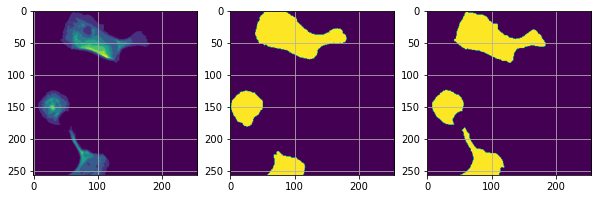

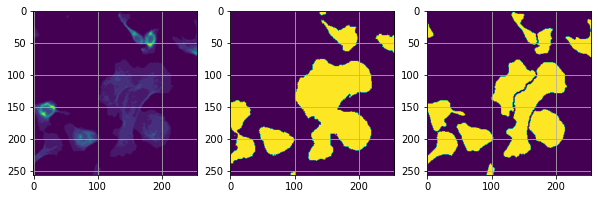

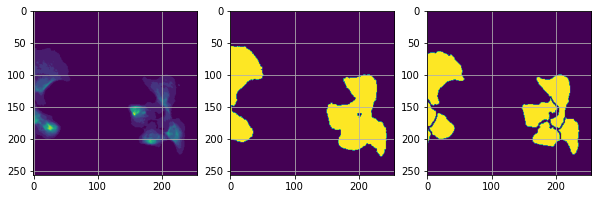

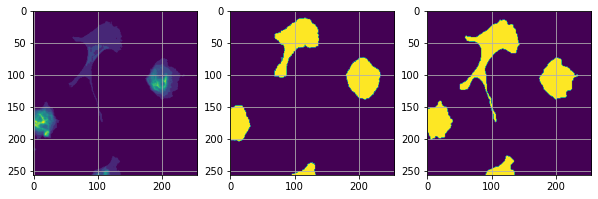

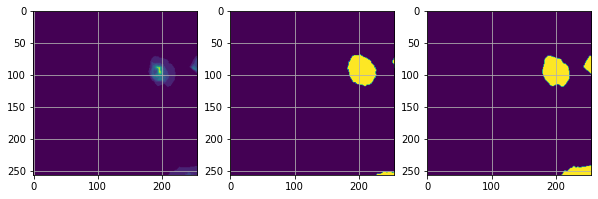

In [28]:
unseen = DataLoader(CellImages(images[95:100], labels[95:100]), batch_size=5, shuffle=False)
inp, pred, ans = test_loop(unseen, handler, loss_fn)
show_cuda_image(5, inp, pred, ans)